## Linear Regression

This notebook is intended for educational purposes and serves as a personal reference for undertanding and implementing linear regression. In this notebook we'll address the topics listed below by working through a dataset on houseprices scraped from Funda

Simple & multiple linear regression:
- Fitting a model
- Assessing the coefficients: hypothesis testing, t-statistic- p-value
- Assessing the model fit: RSE, R-squared, F-statistic
- Potential data problems
- Dealing missing/invalid data: imputation
- Qualitative predictors
- Test train split
- Variable selection

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from ISLP.models import (ModelSpec as MS, 
                         summarize)
import statsmodels.api as sm
import math

### Getting the data

Use the [funda-scraper](https://pypi.org/project/funda-scraper/) to scrape data from funda. In this notebook, we read the Funda data from a pickle file

In [2]:
houses_df = pd.read_pickle('houses_df.pkl')
houses_df.drop(columns=['house_id', 'address', 'descrip'], inplace=True)

### Inspect the data
- Printing head to get a feel of the columns and values
- Checking for NaN values

In [3]:
houses_df.head()

,city,house_type,building_type,price,price_m2,room,bedroom,bathroom,living_area,energy_label,zip,year_built,house_age,date_list,ym_list,year_list
0,amsterdam,appartement,Bestaande bouw,400000,8000.0,2,1,1,50,D,1056,1930,93,2023-08-29,2023-08-01,2023
1,amsterdam,appartement,Bestaande bouw,450000,6923.1,4,3,1,65,C,1091,1960,63,2023-08-29,2023-08-01,2023
2,amsterdam,appartement,Bestaande bouw,300000,4545.5,3,2,1,66,B,1106,1983,40,2023-08-28,2023-08-01,2023
3,amsterdam,appartement,Bestaande bouw,625000,6377.6,3,2,1,98,A,1061,2013,10,2023-08-28,2023-08-01,2023
4,amsterdam,appartement,Bestaande bouw,485000,4754.9,4,3,1,102,D,1024,1967,56,2023-08-29,2023-08-01,2023


In [4]:
houses_df.isnull().values.any()

False

### Choosing living_area as our predictor for simple linear regression

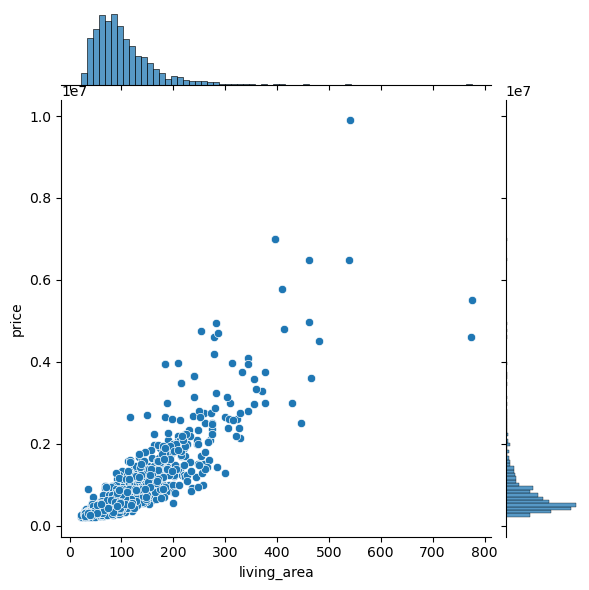

In [5]:
sns.jointplot(y='price', x='living_area', data=houses_df, kind='scatter')

#### Deciding that we don't want to buy a house more expensive than 1,000,0000

Early findings:
- Price most dense around €500,000
- Living area most dense around 80 $m^2$
- Relationship seems linear, number of outliers increases for prices/living_area

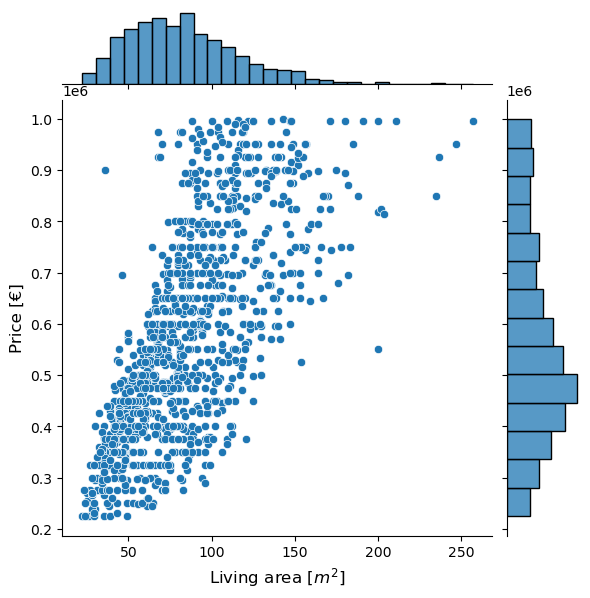

In [8]:
mil_df = houses_df[houses_df.price<1000000]
jplot = sns.jointplot(y='price', x='living_area', data=mil_df, kind='scatter')
jplot.set_axis_labels('Living area [$m^2$]', 'Price [€]', fontsize=12)

#### Preparing data for simple linear regression
1. We create a dataframe which we can use to fit our linear model
2. Perform the linear regression and print the results

Footnotes:
- Normally, I would use sklearn for linear regression, however with the StatModels libary, it is easier to inspect data statistics, hence using that library in this notebook
- For now, not splitting up in test and training data, we'll do this in the multiple regression section

In [9]:
design = MS(['living_area'])
Xsm = design.fit_transform(mil_df)
Xsm.head()

,intercept,living_area
0,1.0,50
1,1.0,65
2,1.0,66
3,1.0,98
4,1.0,102


In [10]:
ysm = mil_df['price']
model = sm.OLS(ysm, Xsm)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,236100.0000,10300.00,22.894,0.0
living_area,3973.9506,112.88,35.205,0.0


#### Result analysis

- The fitted line intersects the y-axis at 236100 Euro ($\hat \beta_0$)
- Per m2, the price of a house will increase with ~3938 Euro ($\hat \beta_1$)
- Simple linear regression formula: $\hat y = \hat \beta_0 + \hat \beta_1 * x_1$

- The standard error roughly defines how far off the estimates of the coeficients $(\hat{\beta}_0, \hat{\beta}_1)$ are from the actual coefficients $(\beta_0, \beta_1)$. The standard error for the mean of a population:
$$Var(\hat{\mu}) = SE(\hat{\mu})^2 = \frac{\sigma^2}{n}$$
- E.g. we can say with 95% confidence that the true value for $\beta_1$ will be between:
$$\hat{\beta}_1 \pm 2*SE(\hat{\beta}_1) \approx (3748,4200) $$  
- Using the standard error, we can perform hypothesis tests:
    - Null hypothesis, $H_0 : \beta_1 = 0$, X is not statistically significant for Y
    - Alternative hypothesis: $H_a : \beta_1 \neq 0$, There is some relationship between X and Y
    - We need to determine whether our estimate of $\beta_1$ is sufficiently far from zero, so we can say confidently it is non-zero, which we can do with the *t-statistic*:
    $$t = \frac{\hat\beta_1}{SE(\hat\beta_1)} = \frac{\text{Our estimate of } \hat\beta}{\text{How far } \hat\beta \text{ is likely off}} = \text{number of standard deviations }\hat\beta_1 \text{ is away from 0}$$
    - The probability of observing any number equal to *t* or larger in absolute value is called the *p-value*, e.g. there is a *p-value*% chance of observing a substantial relation between the predictor and the response due to chance, e.g. with small *p-values*, we can reject the null hypothesis!




#### Plotting the fit
By eye, we would probably draw a more steep line, however the result of the linear regression (the result of minimizing the squared residuals) is less steep, probably due to the outliers on the righthand side

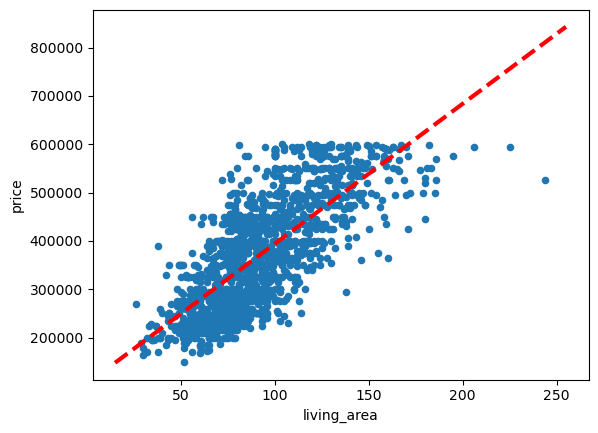

In [8]:
def abline(ax, b, m, *args , **kwargs):
    "Funtion taken from ISLP book, Add a line with slope m and intercept b to ax"
    
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim , ylim , *args , **kwargs)

ax = mil_df.plot.scatter('living_area', 'price')
abline(ax, results.params[0], results.params[1], 'r--', linewidth=3)

##### Assessing the goodness of the fit using $R^2$

We find that $R^2$ is 0.505, which means: 50.5% of the variability in the response is explained/removed by performing the regression

Further explanation on $R^2$:

$$ R^2 = \frac{TSS-RSS}{TSS} = 1 - \frac{RSS}{TSS} $$

Where $TSS$ is the variance around the mean (simplest estimate we can make) and $RSS$ is the *residual sum of squares*

$$TSS = \sum (y_i-\bar{y})^2 $$
$$RSS = \sum_{i=1}^n (y_i -\hat{y}_i)^2$$

The Residual Standard Error (RSE), is an estimate of the standard deviation of the prediction error $\epsilon$, i.e. the average amount that the response will deviate from the true regression line
$$RSE = \sqrt{\frac{1}{n-2}RSS}$$

The F-statistic is a way to determine wheter $R^2$ is statistically significant

$$ F = \frac{(TSS-RSS)/p}{RSS/(n-p-1)} $$

How to go from the F-statistic to the p-value:
1. Calculate F for $n$ different data sets with random data points and fill a histograms
2. Plot F on the histogram, p-value is the number of more extreme values divided by $n$, i.e. the probability that we will have a larger F-value

In [11]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     1239.
Date:                Thu, 21 Sep 2023   Prob (F-statistic):          8.14e-188
Time:                        14:58:14   Log-Likelihood:                -16157.
No. Observations:                1219   AIC:                         3.232e+04
Df Residuals:                    1217   BIC:                         3.233e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    2.361e+05   1.03e+04     22.894      0.000    2.16e+05    2.56e+05
living_area  3973.9506    112.880     35.205      0.000    3752.489    4195.412
==============================================================================
Omnibus:                       22.624   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.925
Skew:                           0.306   Prob(JB):                     6.38e-06
Kurtosis:                       3.310   Cond. No.                         238.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Using our model to predict prices of a houses with various living_area

In [12]:
new_df = pd.DataFrame({'living_area': [50, 100, 150]})
new_X = design.transform(new_df)
new_predictions = results.get_prediction(new_X)
new_predictions.predicted_mean

array([434838.08305015, 633535.61461701, 832233.14618386])

And the related confidence intervals are:

In [13]:
new_predictions.conf_int(alpha=0.05)

array([[423963.20889811, 445712.95720219],
       [625036.25165626, 642034.97757776],
       [815757.65163355, 848708.64073418]])

I believe the confidence interval is very narrow, wrt the residual plot, how is that possible? --> Residuals are not constant over the fitted values
Next step: investigate potential issues with the data by checking residuals etc.

#### Potential inconsistencies in the data

1. **Non-linearity of the data**: residual plots are a useful graphical tool for identifying non-linearity. As we also want to check the residuals for multiple linear regression (more than one predictor), the residuals are plotted the predicted (or fitted) values $\hat y$. Ideally, no pattern is visible in the residual plot. A pattern in the residuals could be resolved by using non-linear transformations of the predictor, e.g. $X^2$. Clearly a pattern is visible in our case, however, this could also be caused by non-constant variance of error terms (funnel shape, see bullet 3)
2. **Correlation of Error terms**: $\epsilon_i$ affects $\epsilon_{i + 1}$, often happens in time series, not in this case
3. **Non-constant variance of error terms (heteroscedasticity)**: The error terms **must** have a constant variance, Var($\epsilon_i$) as the standard errors, confidence intervals and hypothesis tests rely upon this assumption. We can identify heteroscedasticity from the presence of a funnel shape in the residual plot. A potential solution is to transform the response *Y* using a concave function
4. **Outliers**: $y_i$ is far from the value predicted by the model $\hat y_i$, can be identified by *residual plots* but also by *studentized residual plots* (dividing the residuals by its estimated standard error, studentized residuals larger than 3 are considered a problem)
5. **High leverage points**: observations with an unusal value for $x_i$ (not $y_i$, which are outliers). The *leverage statistic* is a way to quantify an observation's leverage:
$$ h_i = \frac{1}{n} + \frac{(x_i- \bar x)^2}{\sum (x_{i'} - \bar x)^2}$$

![Alt text](studentized_residuals_vs_leverage.png)

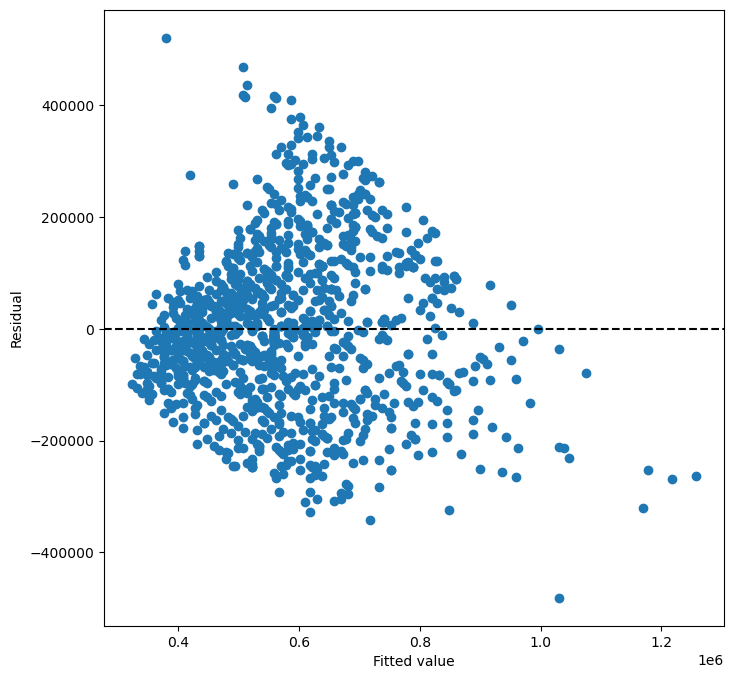

In [14]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues , results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

### Multiple linear regression

Let's select more variables to predict price

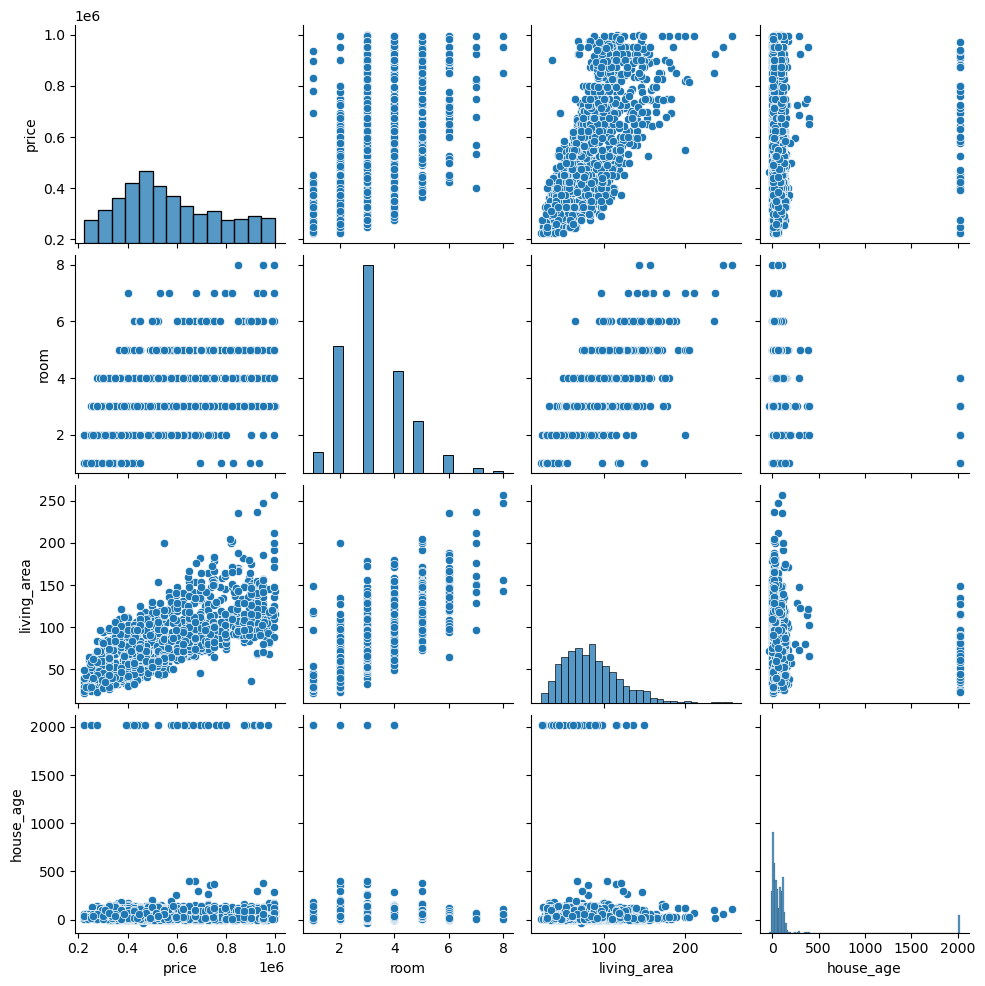

In [16]:
multiple_df = mil_df[['house_type', 'price', 'room', 'living_area', 'energy_label', 'house_age']]
sns.pairplot(data=multiple_df)

#### Dealing with invalid data
Apparently, some houses have an house_age of 2023, probably caused because the building year was not entered (0), which is invalid. For now, we enter the median value of the valid house_age for the invalid entries

In [17]:
house_age_med = multiple_df[multiple_df['house_age']<1500].house_age.median()
print(f"Median house age: {house_age_med}")
multiple_df.loc[multiple_df['house_age']>1500, 'house_age'] = house_age_med

Median house age: 43.0


#### Processing qualitative predictors

Besides quantitative predictors, now we also consider qualitative predictors energy_label and house_type. Their corresponding labels are printed below. There are multiple ways to deal with the categorical variables, some of them are:
1. Dropping them
2. Ordinal encoding -> Transforming each label to a corresponding integer. Applicable in case ofindisputable ranking of the categories ([Kaggle](https://www.kaggle.com/code/alexisbcook/categorical-variables))
3. One-hot encoding -> Creating new columns indicating the presence (or absence) of each possible value in the original data (dummy variables)

Although energy_label seems to be applicable for ordinal encoding, I don't know whether the relationship between specific categories is linear, which I would assume by simply assigning integers, hence, I decide to also use one-hot encoding for the energy_label predictor

In [18]:
print('Different labels in house_type:', multiple_df.house_type.unique(), '\n Different labels in energy_label:', multiple_df.energy_label.unique())

Different labels in house_type: ['appartement' 'huis'] 
 Different labels in energy_label: ['D' 'C' 'B' 'A' '>A+' 'F' 'E' 'G' 'na']


In [ ]:
multiple_df['house_type'] = multiple_df['house_type'].astype('category')
multiple_df['energy_label'] = multiple_df['energy_label'].astype('category')
multiple_df['room'] = multiple_df['room'].astype('int')

Below we'll initiate the multiple regression, once performed we'll address the following topics:

1. Is there a relation between the response and the predictors, i.e. can we reject $H_0$? -> Is the F-statistic not close to 1?
2. Deciding on important predictors: forward selection, backward selection, and mixed selection
3. Assessing the model fit: checking the RSE and $R^2$
4. Predict using the derived model

In [20]:
allvars = multiple_df.columns.drop('price')
y_multiple = multiple_df['price']
X_multiple = MS(allvars).fit_transform(multiple_df)
X_multiple

,intercept,house_type[huis],room,living_area,energy_label[A],energy_label[B],energy_label[C],energy_label[D],energy_label[E],energy_label[F],energy_label[G],energy_label[na],house_age
0,1.0,0.0,2,50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,93
1,1.0,0.0,4,65,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,63
2,1.0,0.0,3,66,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,1.0,0.0,3,98,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
4,1.0,0.0,4,102,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1520,1.0,1.0,5,118,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,69
1521,1.0,1.0,5,75,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,62
1522,1.0,1.0,8,247,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,59
1523,1.0,0.0,2,60,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42


#### Splitting our data in a test and training set

Optionally discuss cross-validation here

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_multiple, y_multiple, test_size=0.2, random_state=0)

#### Fitting the model and showing the results

In [22]:
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     104.9
Date:                Thu, 21 Sep 2023   Prob (F-statistic):          2.01e-165
Time:                        15:01:15   Log-Likelihood:                -12860.
No. Observations:                 975   AIC:                         2.575e+04
Df Residuals:                     962   BIC:                         2.581e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         2.506e+05   2.19e+04     11.451      0.000    2.08e+05    2.94e+05
house_type[huis]  -1.05e+05   1.39e+04     -7.527      0.000   -1.32e+05   -7.76e+04
room              1929.5882   5812.877      0.332      0.740   -9477.793    1.33e+04
living_area       4417.5201    194.436     22.720      0.000    4035.953    4799.087
energy_label[A]  -8.611e+04   1.84e+04     -4.668      0.000   -1.22e+05   -4.99e+04
energy_label[B]  -9.964e+04   2.06e+04     -4.827      0.000    -1.4e+05   -5.91e+04
energy_label[C]  -1.293e+05      2e+04     -6.452      0.000   -1.69e+05      -9e+04
energy_label[D]  -1.101e+05   2.14e+04     -5.150      0.000   -1.52e+05   -6.81e+04
energy_label[E]  -1.433e+05   2.63e+04     -5.446      0.000   -1.95e+05   -9.16e+04
energy_label[F]  -1.172e+05   3.07e+04     -3.816      0.000   -1.77e+05   -5.69e+04
energy_label[G]  -1.468e+05   3.63e+04     -4.047      0.000   -2.18e+05   -7.56e+04
energy_label[na] -3.692e+04    1.9e+04     -1.938      0.053   -7.43e+04     466.767
house_age          775.6568     94.308      8.225      0.000     590.583     960.730
==============================================================================
Omnibus:                       47.260   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.989
Skew:                           0.340   Prob(JB):                     7.82e-20
Kurtosis:                       4.305   Cond. No.                     1.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### First result analysis and variable selection
- F-statistic > 1, indicatingt $R^2$ is significant and evidence to reject $H_0$, i.e. at least one of the predictors is related to the house price
- Variable selection: Now we have rejected $H_0$, we'll assess whether we want to include all off the predictors in our model. Ideally, we would like check all possible models, however, with the large number of predictors this would require us to check $2^p = 4096$ -> not feasible. Three classical methods to proceed are:
    - Forward selection: Begin with the *null model*, a model that only contains the intercept. Then fit $p$ simple linear regressions and add to the null model the variable with lowest RSS. Continue till a stopping rule is satisfied
    - Backward selection: Start with all variables and remove the variable with the largest p-value. Repeat till a stopping criterion is met **(we'll apply this method here)**
    - Mixed selection: Start with *null model* and add first best variable (based on RSS) and keep adding variables. As soon as p-value of one of the variables exceeds threshold, take that variable out and add other variable
    
Taking out room and energy_label[na]

In [23]:
model = sm.OLS(y_train, X_train.drop(columns=['room', 'energy_label[na]']))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     125.3
Date:                Thu, 21 Sep 2023   Prob (F-statistic):          1.09e-166
Time:                        15:01:29   Log-Likelihood:                -12862.
No. Observations:                 975   AIC:                         2.575e+04
Df Residuals:                     964   BIC:                         2.580e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         2.219e+05   1.43e+04     15.536      0.000    1.94e+05     2.5e+05
house_type[huis] -1.034e+05    1.3e+04     -7.967      0.000   -1.29e+05    -7.8e+04
living_area       4497.0356    137.847     32.623      0.000    4226.520    4767.551
energy_label[A]  -5.868e+04    1.2e+04     -4.900      0.000   -8.22e+04   -3.52e+04
energy_label[B]  -7.184e+04    1.5e+04     -4.798      0.000   -1.01e+05   -4.25e+04
energy_label[C]  -1.007e+05   1.38e+04     -7.306      0.000   -1.28e+05   -7.36e+04
energy_label[D]  -8.151e+04   1.57e+04     -5.196      0.000   -1.12e+05   -5.07e+04
energy_label[E]  -1.146e+05   2.19e+04     -5.225      0.000   -1.58e+05   -7.16e+04
energy_label[F]  -8.879e+04   2.71e+04     -3.273      0.001   -1.42e+05   -3.56e+04
energy_label[G]  -1.187e+05   3.33e+04     -3.560      0.000   -1.84e+05   -5.33e+04
house_age          776.1568     94.277      8.233      0.000     591.145     961.169
==============================================================================
Omnibus:                       46.177   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.474
Skew:                           0.330   Prob(JB):                     1.67e-19
Kurtosis:                       4.301   Cond. No.                         919.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

3. Assessing model fit: 
    - $R^2$ is 0.565, 56.5% of the variance is removed by the multiple regression
    - Residual standard error (RSE) is 130596 Euro, which is ~23% off 

In [24]:
def model_fit(y_train, X_train, results):
    n = len(y_train)
    p = len(X_train.columns) - 1
    RSE_multiple = math.sqrt((1/(n-p-1))*sum((results - y_train)**2))
    print(f"RSE: {RSE_multiple}")
    RSE_p_multiple = RSE_multiple/y_train.mean()
    print(f"RSE in percentage: {RSE_p_multiple}")
    return RSE_multiple, RSE_p_multiple

RSE_multiple, RSE_p_multiple = model_fit(y_train, X_train, results.fittedvalues)

RSE: 130596.48128908273
RSE in percentage: 0.22965675180879863


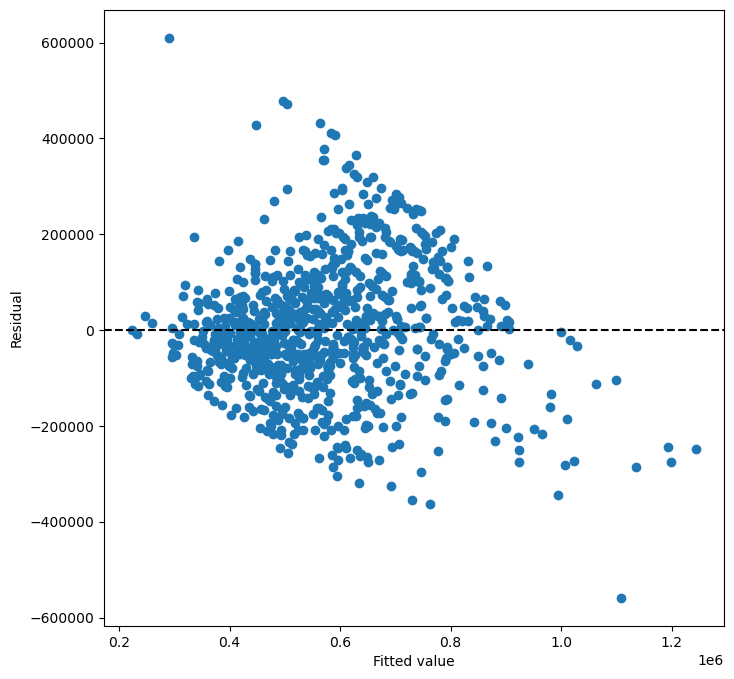

In [25]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues , results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

#### Predicting

In [26]:
results_test = results.get_prediction(X_test.drop(columns=['room', 'energy_label[na]']))
RSE_test, RSE_p_test =  model_fit(y_test, X_test, results_test.predicted_mean)

RSE: 122416.69486896832
RSE in percentage: 0.21007046438196497


### Some draft functions to play around

### Play around with interactive plots

In [ ]:
import plotly.express as px


# Create an interactive scatter plot with Plotly
fig = px.scatter(
    temp_df,
    x='living_area',
    y='price',
    trendline='ols',  # Add a trendline to the plot
    hover_data=['address'],  # This sets the text that will appear on hover
    title='Price vs Living Area',
    labels={'living_area': 'Living Area', 'price': 'Price'},
    template='plotly',  # You can choose a different template if you prefer
)

# Customize the hover text
fig.update_traces(textposition='top center')

# Update layout for better aesthetics
fig.update_layout(
    hovermode='closest',
    xaxis=dict(showgrid=True, title_standoff=10),
    yaxis=dict(showgrid=True, title_standoff=10),
    title_x=0.5,  # Center the title
)

# Show the plot
fig.show()


#### Apply simple linear regression using sklearn

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X, y)
reg.coef_
reg.intercept_
print('R^2: ', reg.score(X_test, y_test), '\n', 'Slope: ', reg.coef_, '\n', 'Intercept: ', reg.intercept_) 

fig, ax = plt.subplots()
ax.plot(X_test, reg.predict(X_test), label='data')
ax.scatter(X_train, y_train, label='data', c='g')

### Color by listed date

In [ ]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
# sns.scatterplot(data=houses_df, x='living_area', y='price', hue = 'date_list',  palette='RdBu', ax = ax)

plt.scatter(houses_df['living_area'], houses_df['price'], c=mdates.date2num(houses_df['date_list']), cmap='viridis', alpha=0.8)
cb = plt.colorbar()
loc = mdates.AutoDateLocator()
cb.ax.yaxis.set_major_locator(loc)
cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
ax.set_ylim(200000, 500000)
ax.set_xlim(20, 150)
ax.set_ylabel('Price (€)')
ax.set_xlabel('Living Area (m2)')
ax.set_title('House Price vs Living Area, colored by Listing Date')


In [ ]:
houses_df.date_list.hist(bins = 100)